In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling Congestion and Pricing Transmission Rights in Coupled Power Markets

## Preprocessing des données

For data preprocessing, we downloaded day-ahead prices for France and Germany from ENTSO-E, then merged the time series on common dates before creating a new column representing the hourly spread.

In [212]:
df = pd.read_csv('clean_data.csv')

## Identification of congestion patterns

In [213]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['quarter'] = df['datetime'].dt.quarter


monthly_spreads = df.groupby(['year', 'month'])['spread'].mean()
monthly_df = monthly_spreads.reset_index()
monthly_df.columns = ['year', 'month', 'monthly_mean_spread']

In [214]:
yearly_thresholds = monthly_df.groupby(monthly_df['year'])['monthly_mean_spread'].apply(
    lambda x: x.abs().quantile(0.70)
)
print(yearly_thresholds)

year
2022    46.295054
2023     8.205579
2024    27.232599
Name: monthly_mean_spread, dtype: float64


Congestion levels show heterogeneity across years => differences in market conditions between 2022, 2023 and 2024

In [215]:
threshold = monthly_df['monthly_mean_spread'].abs().quantile(0.70)
print(threshold)

27.224630376344088


Despite these differences, a single global threshold was retained for the full sample => apply consistente congestion definition across years

In [216]:
df['congestion'] = df['spread'].abs() > threshold
df['congestion_sign'] = np.sign(df['spread']) * df['congestion']

df['event_id'] = (df['congestion'] != df['congestion'].shift(1)).cumsum()
congestion_events = df[df['congestion']].groupby('event_id')

We consider that an hour is binding if the spread is higher than the threshold value.

### Statistiques

In [217]:
event_stats = [] 
for event_id, group in congestion_events: 
    event_stats.append({ 
        'event_id': event_id, 
        'start_time': group['datetime'].iloc[0], 
        'end_time': group['datetime'].iloc[-1], 
        'duration_hours': len(group), 
        'mean_spread': group['spread'].mean(), 
        'max_spread': group['spread'].abs().max(), 
        'min_spread': group['spread'].abs().min(), 
        'direction': 'DE > FR' if group['spread'].mean() > 0 else 'FR > DE', 
        'magnitude_avg': group['spread'].abs().mean(), 
        'magnitude_max': group['spread'].abs().max() }) 
    
events_df = pd.DataFrame(event_stats) # Résumé 
print("Statistiques ") 
print(f"Nulber of events : {len(events_df)}") 
print(f"freq : {len(events_df) / (df['datetime'].max() - df['datetime'].min()).days * 30:.2f} ") 
print(f"average duration : {events_df['duration_hours'].mean():.2f} heures") 
print(f"median duration : {events_df['duration_hours'].median():.2f} heures") 
print(f"av magnitude : {events_df['magnitude_avg'].mean():.2f} €/MWh") 
print(f"max magnitude : {events_df['magnitude_max'].max():.2f} €/MWh")
direction_counts = events_df['direction'].value_counts() 
print("congestion directions :") 
print(direction_counts)

Statistiques 
Nulber of events : 1244
freq : 34.08 
average duration : 5.92 heures
median duration : 3.00 heures
av magnitude : 55.16 €/MWh
max magnitude : 2886.62 €/MWh
congestion directions :
direction
DE > FR    669
FR > DE    575
Name: count, dtype: int64


Around 34 congestion events per month. This indicates that price decoupling between France and Germany occurs frequently & represents a recurring feature of market operation.  

Average congestion duration :5.92h  higher than the median duration :3h, indicates an asymmetric distribution. Most congestion events are relatively short, while a smaller number of longer episodes increases the average duration.

Magnitude av : around 55.16eur/mwh : economically meaningful and non negligible

magnitude max : 2886.82 highlights presence of extreme events :presence of tail risk 

Congestion directions = balanced. In 2022, negative spreads are most frequent and in 2024 positive spreads most frequent

## Visualisation

Visualization is a great way to analyse

### Duration hist

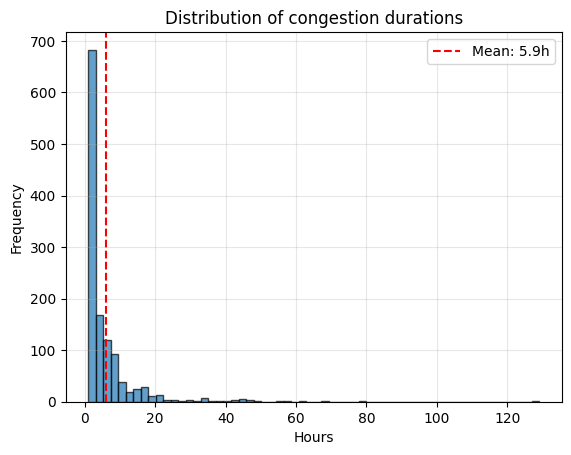

In [218]:
plt.hist(events_df['duration_hours'], bins=60, edgecolor='black', alpha=0.7)
plt.axvline(events_df['duration_hours'].mean(), color='red', linestyle='--', label=f'Mean: {events_df["duration_hours"].mean():.1f}h')
plt.xlabel('Hours')
plt.ylabel('Frequency')
plt.title('Distribution of congestion durations')
plt.legend()
plt.grid(True, alpha=0.3)

Mostly short duration (1-2h) but some few congestion increase average

### Duration vs Magnitude

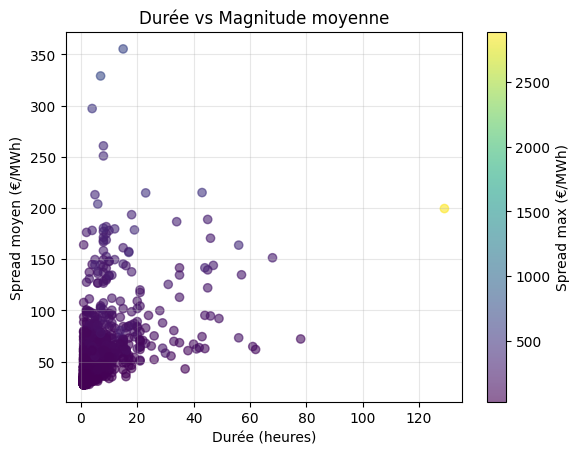

In [219]:
scatter = plt.scatter(events_df['duration_hours'], events_df['magnitude_avg'],
                           c=events_df['magnitude_max'], cmap='viridis', alpha=0.6)
plt.xlabel('Durée (heures)')
plt.ylabel('Spread moyen (€/MWh)')
plt.title('Durée vs Magnitude moyenne')
plt.colorbar(scatter, label='Spread max (€/MWh)')
plt.grid(True, alpha=0.3)

### seasonality

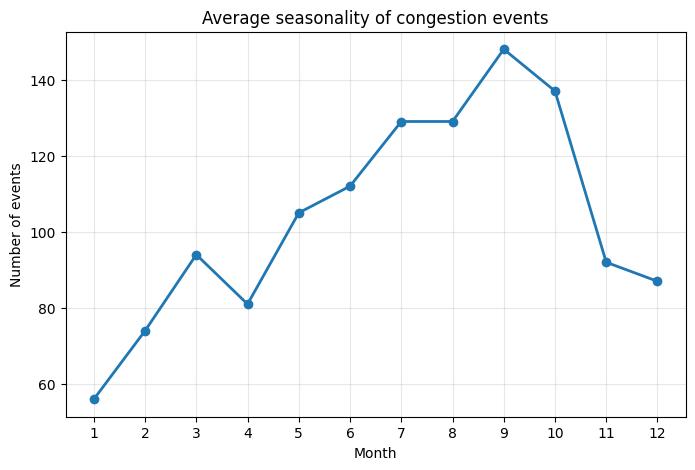

In [220]:
events_df['month'] = events_df['start_time'].dt.month
monthly_counts = events_df.groupby('month').size()
plt.figure(figsize=(8,5))
plt.plot(monthly_counts.index, monthly_counts.values, marker='o', linewidth=2)
plt.xlabel('Month')
plt.ylabel('Number of events')
plt.title('Average seasonality of congestion events')
plt.xticks(range(1, 13))
plt.grid(True, alpha=0.3)

Pic of congestions in september. Pattern can be linked to factors : nuclear maintenance schedules, changes in electricity demand after summer, increased variability in renewable generation.

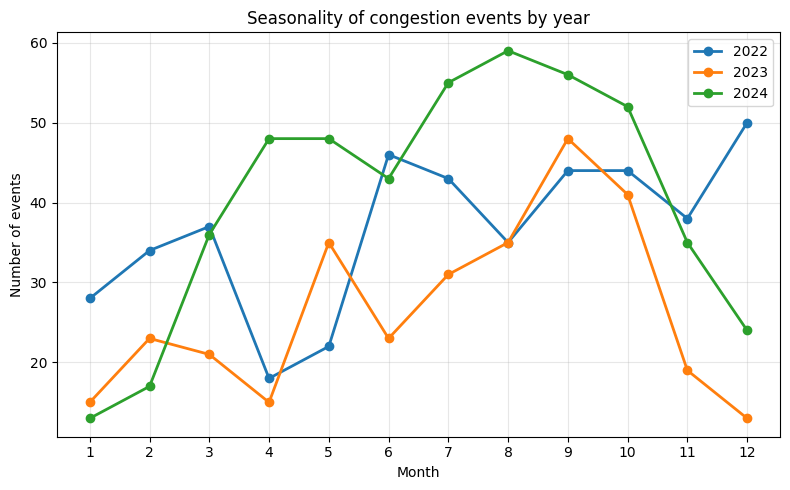

In [221]:
events_df['year'] = events_df['start_time'].dt.year
monthly_counts = events_df.groupby(['year', 'month']).size()

plt.figure(figsize=(8,5))

for year in monthly_counts.index.get_level_values(0).unique():
    data_year = monthly_counts.loc[year]
    
    plt.plot(
        data_year.index,
        data_year.values,
        marker='o',
        linewidth=2,
        label=str(year)
    )

plt.xlabel('Month')
plt.ylabel('Number of events')
plt.title('Seasonality of congestion events by year')
plt.xticks(range(1, 13))
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


### Saisonnalité horaire

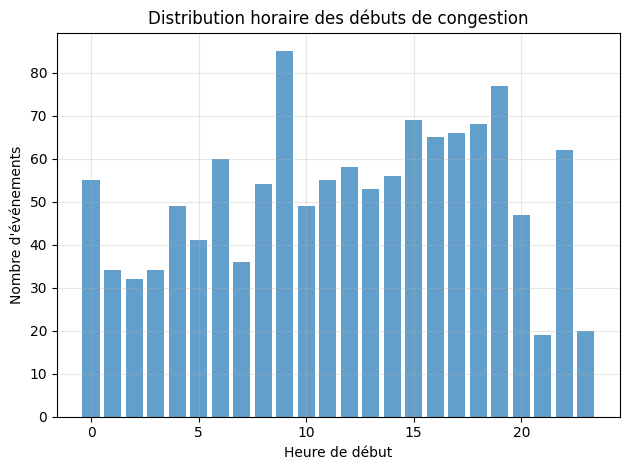

In [222]:
events_df['hour'] = events_df['start_time'].dt.hour
hourly_counts = events_df.groupby('hour').size()
plt.bar(hourly_counts.index, hourly_counts.values, alpha=0.7)
plt.xlabel('Heure de début')
plt.ylabel('Nombre d\'événements')
plt.title('Distribution horaire des débuts de congestion')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [223]:
print("10 congestion events with highest intensity")
top_events = events_df.nlargest(10, 'magnitude_max')[['start_time', 'end_time', 'duration_hours',
                                                       'mean_spread', 'max_spread', 'direction']]
print(top_events.to_string())

events_df.to_csv('congestion_events_analysis.csv', index=False)


10 congestion events with highest intensity
              start_time            end_time  duration_hours  mean_spread  max_spread direction
98   2022-03-31 08:00:00 2022-04-05 16:00:00             129  -199.474651     2886.62   FR > DE
1191 2024-11-06 13:00:00 2024-11-06 19:00:00               7   328.960000      692.08   DE > FR
1229 2024-12-12 05:00:00 2024-12-12 19:00:00              15   355.357333      661.28   DE > FR
1080 2024-09-03 16:00:00 2024-09-03 19:00:00               4   297.145000      521.32   DE > FR
211  2022-07-19 08:00:00 2022-07-21 02:00:00              43  -215.097442      486.78   FR > DE
221  2022-07-26 07:00:00 2022-07-27 05:00:00              23  -214.753043      470.42   FR > DE
214  2022-07-22 07:00:00 2022-07-22 23:00:00              17  -156.640000      444.95   FR > DE
573  2023-07-02 11:00:00 2023-07-02 16:00:00               6  -203.868333      444.34   FR > DE
256  2022-08-28 10:00:00 2022-08-28 17:00:00               8  -260.710000      392.01   FR >

7 des plus gros évènements sont en 2022. Cela confirme ce qu'on a déjà vu.    

58  2022-04-03 17:00:00 2022-04-05 10:00:00  => congestion pendant presque 2jours. Très rentable pour détenteur de FTR et dangereux pour autres.
France souvent plus chère que Allemagne : réflexion de l'indisponibilité nucléaire en France en 2022

### Spread pendant et hors congestion

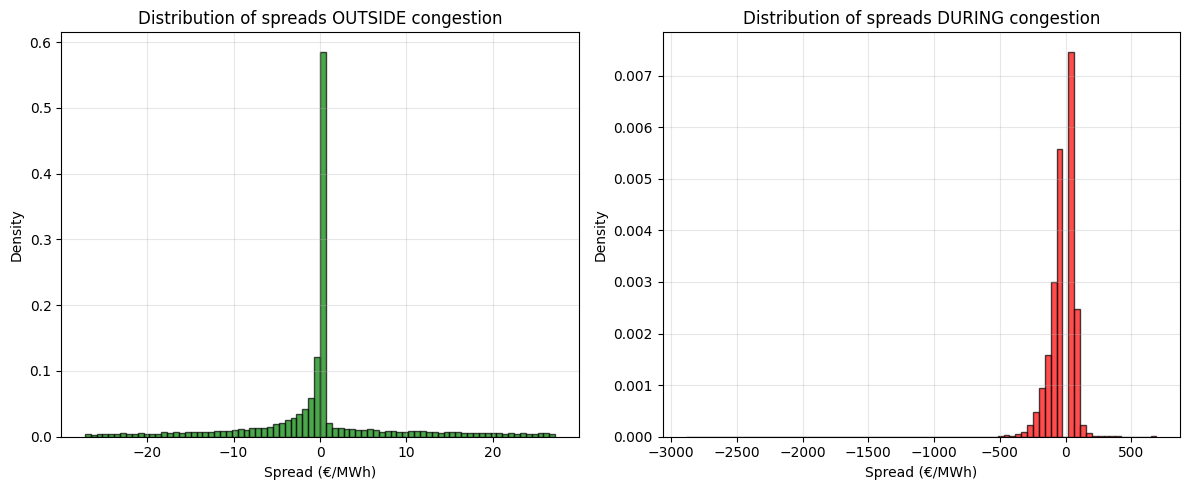

In [224]:
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

normal_spreads = df[~df['congestion']]['spread']
ax1.hist(normal_spreads, bins=80, alpha=0.7, edgecolor='black', color='green', density=True)
ax1.set_xlabel('Spread (€/MWh)')
ax1.set_ylabel('Density')
ax1.set_title('Distribution of spreads OUTSIDE congestion')
ax1.grid(True, alpha=0.3)

congestion_spreads = df[df['congestion']]['spread']
ax2.hist(congestion_spreads, bins=80, alpha=0.7, edgecolor='black', color='red', density=True)
ax2.set_xlabel('Spread (€/MWh)')
ax2.set_ylabel('Density')
ax2.set_title('Distribution of spreads DURING congestion')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Outside congestion periods : spreads strongly concentrated around 0 €/MWh with low dispersion. This indicates efficient market coupling and strong price convergence between France and Germany under normal operating conditions

During congestion : spread distribution becomes wider and more dispersed. Larger price differences, more frequently and extreme values become more likely => impact of transmission constraints on cross-border arbitrage.


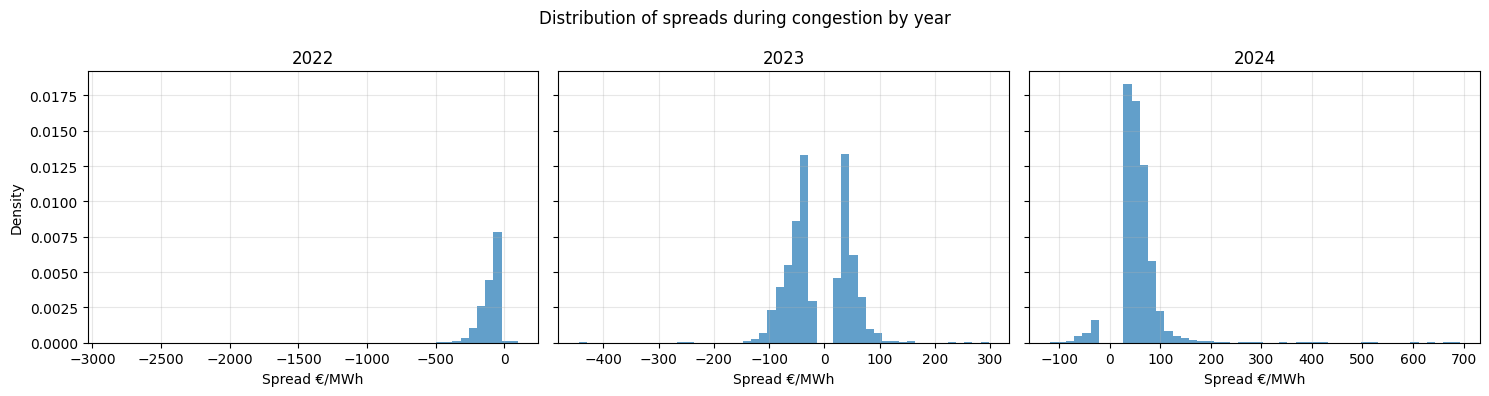

In [225]:
df['year'] = df['datetime'].dt.year

df_2022 = df[df['year'] == 2022]
df_2023 = df[df['year'] == 2023]
df_2024 = df[df['year'] == 2024]
spreads_2022_cong = df_2022[df_2022['congestion']]['spread']
spreads_2023_cong = df_2023[df_2023['congestion']]['spread']
spreads_2024_cong = df_2024[df_2024['congestion']]['spread']

fig, axes = plt.subplots(1, 3, figsize=(15,4), sharey=True)

years = [2022, 2023, 2024]
datasets = [spreads_2022_cong, spreads_2023_cong, spreads_2024_cong]

for ax, y, data in zip(axes, years, datasets):
    ax.hist(data, bins=50, density=True, alpha=0.7)
    ax.set_title(str(y))
    ax.set_xlabel("Spread €/MWh")
    ax.grid(alpha=0.3)

axes[0].set_ylabel("Density")

plt.suptitle("Distribution of spreads during congestion by year")
plt.tight_layout()
plt.show()



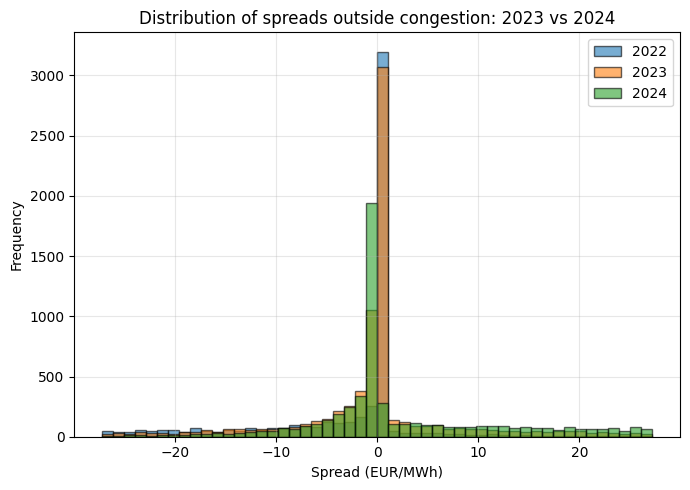

In [226]:
spreads_2022_normal = df_2022[~df_2022['congestion']]['spread']
spreads_2023_normal = df_2023[~df_2023['congestion']]['spread']
spreads_2024_normal = df_2024[~df_2024['congestion']]['spread']

plt.figure(figsize=(7,5))

plt.hist(spreads_2022_normal, bins=50, alpha=0.6, edgecolor='black', label='2022')
plt.hist(spreads_2023_normal, bins=50, alpha=0.6, edgecolor='black', label='2023')
plt.hist(spreads_2024_normal, bins=50, alpha=0.6, edgecolor='black', label='2024')

plt.xlabel('Spread (EUR/MWh)')
plt.ylabel('Frequency')
plt.title('Distribution of spreads outside congestion: 2023 vs 2024')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [227]:
correlation = events_df['duration_hours'].corr(events_df['magnitude_avg'])
print(correlation)

0.44769869020434644


Long congestion events tend to be more intense : not only short-lived price spikes

## Definition of FTR

As suggested, we define the FTR as an option written on monthly average price spread

In [228]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['quarter'] = df['datetime'].dt.quarter

# spreads moyens
monthly_spreads = df.groupby(['year', 'month'])['spread'].mean()

monthly_df = monthly_spreads.reset_index()
monthly_df.columns = ['year', 'month', 'monthly_mean_spread']

print("Exemple de monthly_df:")
print(monthly_df.head())

Exemple de monthly_df:
   year  month  monthly_mean_spread
0  2022      1           -43.342769
1  2022      2           -56.367812
2  2022      3           -42.679704
3  2022      4           -67.238250
4  2022      5           -19.670793


### Pay-offs visualization

Payoff = gain financier obtenu par celui qui détient FTR

In [229]:
monthly_df['ftr_payoff'] = np.maximum(monthly_df['monthly_mean_spread'], 0)

print("Statistiques payoffs")
print(f"average: {monthly_df['ftr_payoff'].mean():.2f} ")
print(f"median :{monthly_df['ftr_payoff'].median():.2f} ")
print(f"Std: {monthly_df['ftr_payoff'].std():.2f} ")
print(f"Max: {monthly_df['ftr_payoff'].max():.2f} ")
print(f"Min: {monthly_df['ftr_payoff'].min():.2f} ")

Statistiques payoffs
average: 7.67 
median :0.04 
Std: 12.03 
Max: 40.50 
Min: 0.00 


## Pricing of FTR

### 1. First method : Spreads moyens historiques
Tout d'abord, nous allons réaliser une valorisation par moyenne historique 

Average historical price

In [230]:
historical_price = monthly_df['ftr_payoff'].mean()
print(historical_price)

7.674307008096656


confidence interval

In [231]:
n_months = len(monthly_df)
std_payoff = monthly_df['ftr_payoff'].std()
conf_interval = 1.96 * std_payoff / np.sqrt(n_months)  # 95% CI
print('standard deviation payoffs:')
print(std_payoff)
print ('confidence interval 95% :')
print(f"[{historical_price - conf_interval:.2f}, "
      f"{historical_price + conf_interval:.2f}]")

standard deviation payoffs:
12.03355455427016
confidence interval 95% :
[3.74, 11.61]


Annualized price (over one year) & frequency of non-zero payoffs

In [232]:
annual_price = historical_price * 12
print(annual_price)

non_zero_prob = (monthly_df['ftr_payoff'] > 0).mean()
print(non_zero_prob*100)

92.09168409715987
52.77777777777778


The right to receive the monthly France–Germany price spread has an average value of 7.67 €/MWh over the 2022–2024 period. This corresponds to the fair price that a market participant should be willing to pay to hedge against FR -> DE congestion

### Method 2 : The two-state Markov model

The two-state Markov model is based on assumption that the franch-german electricity market alternates between 2states : normal and congestion. The transition between the 2 states is modeled by a discrete Markov chain : the probability of moving from one state to another only depends on the current state.

Physically speaking, a non-zero spread indicates partial network saturation. As discussed in class, if transmissions were infinite, prices would always be equal between bidding zones. So a spread > 1 indicates congestion.

However, a rational agent does not hedge against negligible price differences. Acquiring a FTR involves certain costs in exchange for protection that is conditional. This decision is a matter of cost-benefit analysis.

Reminder : nb months = 36   
Period : 2022-01 à 2024-12.  
Historical value FTR : 7.67 EUR/MWh   
historical stp : 12.03 EUR/MWh

#### Definition of Markov states

In [233]:
monthly_df['state'] = 'normal'
congestion_mask = (monthly_df['monthly_mean_spread'].abs() > threshold) & (monthly_df['monthly_mean_spread'] > 0)
monthly_df.loc[congestion_mask, 'state'] = 'congestion'

print("Distribution des états :")
state_counts = monthly_df['state'].value_counts()
for state, count in state_counts.items():
    percentage = count / len(monthly_df) * 100
    print(f"  {state:12} : {count:3} mois ({percentage:5.1f}%)")

Distribution des états :
  normal       :  32 mois ( 88.9%)
  congestion   :   4 mois ( 11.1%)


Statistiques per state

In [234]:
for state in ['normal', 'congestion']:
    mask = monthly_df['state'] == state
    data = monthly_df.loc[mask, 'monthly_mean_spread']
    payoffs = monthly_df.loc[mask, 'ftr_payoff']

    print(f"\n{state.upper()} :")
    print(f" nb months : {mask.sum()}")
    print(f" mean spread   : {data.mean():.2f} ")
    print(f"  mean FTR payoff : {payoffs.mean():.2f}")
    if len(data) > 1:
        print(f"  std spread : {data.std():.2f}")


NORMAL :
 nb months : 32
 mean spread   : -12.25 
  mean FTR payoff : 4.32
  std spread : 26.92

CONGESTION :
 nb months : 4
 mean spread   : 34.48 
  mean FTR payoff : 34.48
  std spread : 5.34


Germany is on average more competitive (–12.25 €/MWh) and the FTR provides limited protection (4.32 €/MWh).  
There are rare congestion episodes (11% of the time) when France becomes significantly more expensive (+34.48 €/MWh).

#### Markov transition matrix : 
P[i,j] = P(état j demain | état i aujourd'hui)

In [235]:
def estimate_markov_matrix(sequence, states):
    n_states = len(states)
    state_to_idx = {state: i for i, state in enumerate(states)}
    P = np.zeros((n_states, n_states))

    for i in range(len(sequence) - 1):
        current = sequence[i]
        next_ = sequence[i + 1]
        P[state_to_idx[current], state_to_idx[next_]] += 1

    row_sums = P.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    P = P / row_sums

    return P, states

In [236]:
state_sequence = monthly_df['state'].tolist()
state_names = ['normal', 'congestion']
P, states = estimate_markov_matrix(state_sequence, state_names)

df_P = pd.DataFrame(P, index=state_names, columns=state_names)
print(df_P.round(3))


            normal  congestion
normal       0.935       0.065
congestion   0.500       0.500


In [237]:
print(P[0,0], P[0,1], P[1,0], P[1,1])

0.9354838709677419 0.06451612903225806 0.5 0.5


P[0,0] : normal to normal : persistence of normal state
P[0,1] : normal to congestion : probability of entering congestion
P[1,0] : congestion to normal : probability of leaving congestion
P[1,1] : congestion to congestion : persistence of congestion


This transition matrix reveals a highly asymmetric market dynamic. The normal regime shows exceptional stability, reflecting generally balanced market conditions where congestion events are rare.

### Markov simulation

In [238]:
def simulate_markov_ftr(P, states, n_simulations=10000, n_months=12):
    n_states = len(states)
    state_to_idx = {state: i for i, state in enumerate(states)}

    state_data = {}
    for state in states:
        mask = monthly_df['state'] == state
        state_data[state] = {
            'spreads': monthly_df.loc[mask, 'monthly_mean_spread'].values,
            'payoffs': monthly_df.loc[mask, 'ftr_payoff'].values
        }

    simulated_payoffs = []

    for sim in range(n_simulations):
        init_probs = [len(state_data[state]['spreads']) for state in states]
        init_probs = np.array(init_probs) / sum(init_probs)
        current_state_idx = np.random.choice(n_states, p=init_probs)

        total_payoff = 0

        for month in range(n_months):
            current_state = states[current_state_idx]

            payoffs = state_data[current_state]['payoffs']
            if len(payoffs) > 0:
                payoff = np.random.choice(payoffs)
            else:
                payoff = 0

            total_payoff += payoff
            current_state_idx = np.random.choice(n_states, p=P[current_state_idx, :])

        simulated_payoffs.append(total_payoff / n_months)

    return np.array(simulated_payoffs)


In [239]:
n_simulations = 10000
n_months = 12
simulated_prices = simulate_markov_ftr(P, state_names, n_simulations, n_months)

#### Results

In [240]:
markov_price = np.mean(simulated_prices)
markov_std = np.std(simulated_prices)
markov_var_95 = np.percentile(simulated_prices, 5)
markov_es_95 = simulated_prices[simulated_prices <= markov_var_95].mean()

print(markov_price)
print(markov_std)
print(markov_var_95)
print(markov_es_95)

7.721568124874238
4.640145780217899
1.7373010217757383
1.0945734585243085


The Markov-based valuation converges with the historical approach (€7.79/MWh versus €7.67/MWh), which validates the robustness of the estimate. The modeled volatility remains lower than the historical volatility. This reflects the model’s ability to smooth out extreme shocks while capturing the core market dynamics.

### Risk measuring

In [241]:
print(markov_var_95)
print(markov_es_95)
print(f"[{markov_price - 1.96*markov_std:.2f}, "
      f"{markov_price + 1.96*markov_std:.2f}] €/MWh")

1.7373010217757383
1.0945734585243085
[-1.37, 16.82] €/MWh


With 95% confidence, its monthly value will not fall below €1.88/MWh (Value at Risk), and in the 5% most adverse scenarios, its average value still reaches €1.18/MWh (Expected Shortfall), thus limiting extreme losses for the investor.

## Comparison of the methods

In [243]:
hp = monthly_df['ftr_payoff']

historical_price = hp.mean()
historical_std = hp.std()
historical_var_95 = hp.quantile(0.05)
historical_es_95 = hp[hp <= historical_var_95].mean()

print("Historical method:")
print("Price:", round(historical_price, 2))
print("Std:", round(historical_std, 2))
print("VaR 95%:", round(historical_var_95, 2))
print("ES 95%:", round(historical_es_95, 2))

print("Markov method:")
print("Price:", round(markov_price, 2))
print("Std:", round(markov_std, 2))
print("VaR 95%:", round(markov_var_95, 2))
print("ES 95%:", round(markov_es_95, 2))

diff_percent = abs(markov_price - historical_price) / historical_price * 100
print("Relative difference (%):", round(diff_percent, 1))


Historical method:
Price: 7.67
Std: 12.03
VaR 95%: 0.0
ES 95%: 0.0
Markov method:
Price: 7.72
Std: 4.64
VaR 95%: 1.74
ES 95%: 1.09
Relative difference (%): 0.6


The differences in risk measures highlight the value of dynamic modeling. It identifies and quantifies downside risk that the purely historical approach, which is blind to regime persistence, cannot detect. The historical model does not capture any tail risk (VaR and ES at €0), whereas the Markov model shows a moderate residual risk.

## Visualization of the data

#### Distribution of historical payoffs

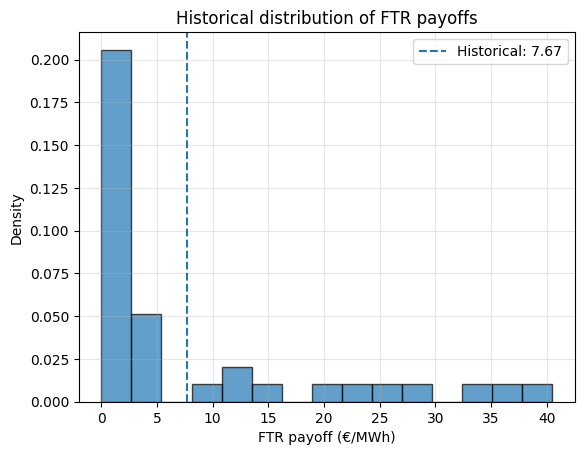

In [244]:
plt.hist(monthly_df['ftr_payoff'], bins=15, edgecolor='black', alpha=0.7, density=True)
plt.axvline(historical_price, linestyle='--', label=f'Historical: {historical_price:.2f}')

plt.xlabel('FTR payoff (€/MWh)')
plt.ylabel('Density')
plt.title('Historical distribution of FTR payoffs')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


We observe a large concentration of values in the €0–5/MWh range, with a few very high outliers (20–40 €) and an average around €7.7. This highly skewed distribution is typical for an FTR, as most of the time the payoff is low or zero, but there are occasional extreme events that drive the mean upward.

#### Distribution Markov simulation 

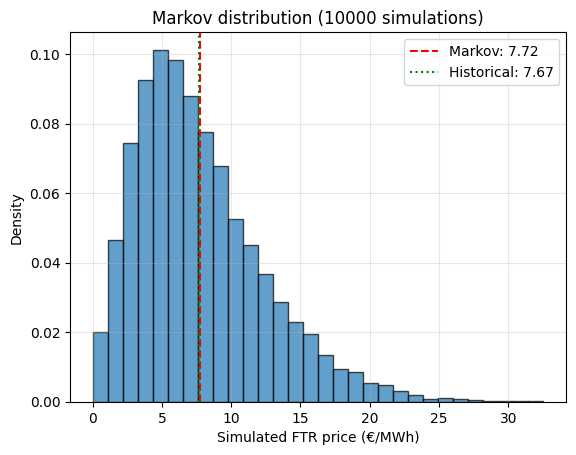

In [247]:
plt.hist(simulated_prices, bins=30, edgecolor='black', alpha=0.7, density=True)
plt.axvline(markov_price, linestyle='--', color = 'red', label=f'Markov: {markov_price:.2f}')
plt.axvline(historical_price, linestyle=':', color = 'green', label=f'Historical: {historical_price:.2f}')

plt.xlabel('Simulated FTR price (€/MWh)')
plt.ylabel('Density')
plt.title(f'Markov distribution ({n_simulations} simulations)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


The shape is smoother and the average is very close to the historical one. The right tail (= extreme payoffs) is still present but less pronounced => the Markov model reduces the impact of rare, extreme events while still capturing the main dynamics of the market

#### Transition Markov matrix

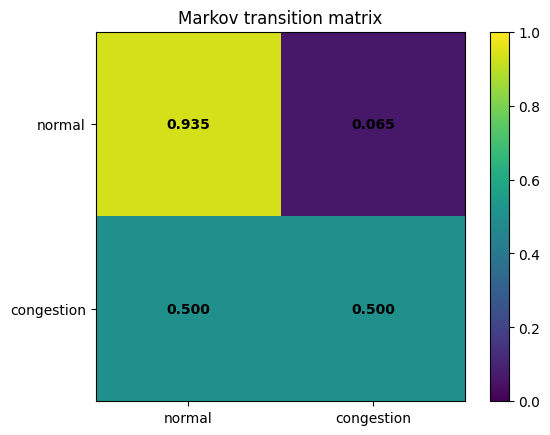

In [249]:
im = plt.imshow(P, vmin=0, vmax=1)
plt.xticks([0,1], state_names)
plt.yticks([0,1], state_names)
plt.title('Markov transition matrix')

for i in range(2):
    for j in range(2):
        plt.text(j, i, f'{P[i,j]:.3f}', ha='center', va='center', fontweight='bold')

plt.colorbar(im)
plt.show()


### Price comparisons

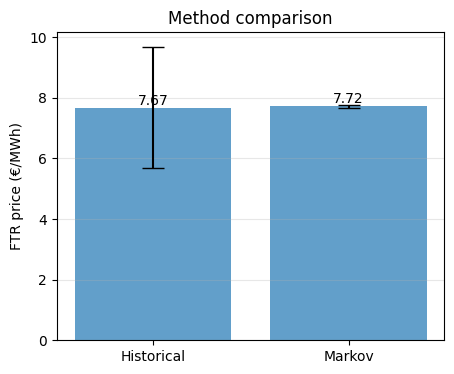

In [250]:
methods = ['Historical', 'Markov']
prices = [historical_price, markov_price]
std_errors = [historical_std/np.sqrt(len(monthly_df)),
              markov_std/np.sqrt(n_simulations)]

x_pos = np.arange(len(methods))

plt.figure(figsize=(5,4))

plt.bar(x_pos, prices, yerr=std_errors, capsize=8, alpha=0.7)
plt.xticks(x_pos, methods)
plt.ylabel('FTR price (€/MWh)')
plt.title('Method comparison')
plt.grid(axis='y', alpha=0.3)

for i, (price, std) in enumerate(zip(prices, std_errors)):
    plt.text(i, price, f'{price:.2f}', ha='center', va='bottom')

plt.show()

### Compared CDF

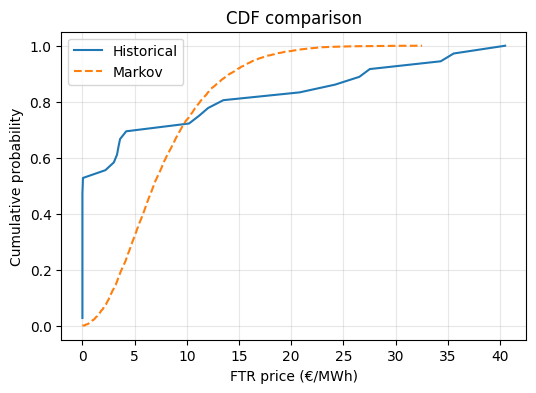

In [251]:
sorted_historical = np.sort(monthly_df['ftr_payoff'])
cdf_historical = np.arange(1, len(sorted_historical)+1) / len(sorted_historical)

sorted_markov = np.sort(simulated_prices)
cdf_markov = np.arange(1, len(sorted_markov)+1) / len(sorted_markov)

plt.figure(figsize=(6,4))

plt.plot(sorted_historical, cdf_historical, label='Historical')
plt.plot(sorted_markov, cdf_markov, linestyle='--', label='Markov')

plt.xlabel('FTR price (€/MWh)')
plt.ylabel('Cumulative probability')
plt.title('CDF comparison')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


We see that the Markov model produces a more concentrated distribution, with most values clustered around the mean, whereas the historical distribution is more dispersed, reflecting greater variability and the presence of more extreme outcomes.

### Temporal evolution (spreads + states)

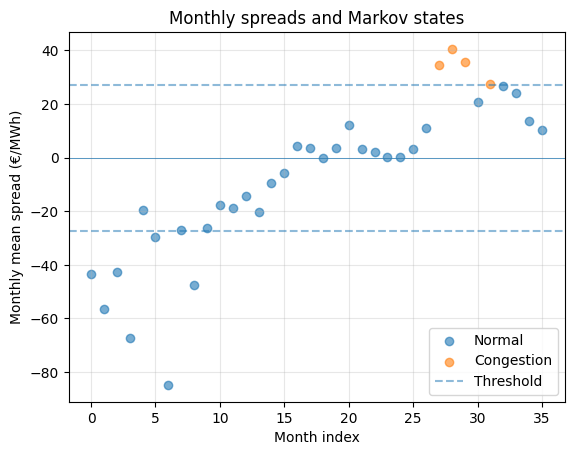

In [252]:
normal_mask = monthly_df['state'] == 'normal'
cong_mask = monthly_df['state'] == 'congestion'

plt.scatter(monthly_df.index[normal_mask],
            monthly_df.loc[normal_mask, 'monthly_mean_spread'],
            label='Normal', alpha=0.6)

plt.scatter(monthly_df.index[cong_mask],
            monthly_df.loc[cong_mask, 'monthly_mean_spread'],
            label='Congestion', alpha=0.6)

plt.axhline(0, linestyle='-', linewidth=0.5)
plt.axhline(threshold, linestyle='--', alpha=0.5, label='Threshold')
plt.axhline(-threshold, linestyle='--', alpha=0.5)

plt.xlabel('Month index')
plt.ylabel('Monthly mean spread (€/MWh)')
plt.title('Monthly spreads and Markov states')
plt.legend()
plt.grid(alpha=0.3)
plt.show()
